# Battle of Neighborhoods_Week2

### Queens, NY

#### 1. Description of the problem

People tend to search the places before visiting a new country, state, city or place for their work. Moreover, if they are going to migrate completely, an analysis of their neighborhood is essential. To meet these needs, we usually need a search algorithm that returns the requested function, such as crime rate, average house price, population percentage, school grade, weather conditions, Distribution of restaurants, etc. It’d be nice to make a convenient program that allow us to analyze all of these features for a neighborhood or a comparative analysis between neighborhoods with just sending out the names of the neighborhoods.

The project is designed to help people get rid of this hassle and do more productive activities in save time.
This project would help people to take a better decision on choosing the best neighborhood out of many neighborhoods to build/buy their houses in New York City based on the distribution of various facilities in and around that neighborhood.

This project uses K-mean clustering algorithm to cluster the venues based on the place category such as restaurants, gym, park, etc. This would give a better understanding of the similarities and dissimilarities between the two chosen neighborhoods to retrieve more insights and to conclude with ease which neighborhood wins over other.

#### 2. Description of the data

In this project,we need the location information of New York City ,which contains list Boroughs, Neighborhoods along with their latitude and longitude. Moreover, we can use Four-square API as its prime data gathering source. In particular, it provides a places API to do location searches and business details. Photos, tips and reviews taken by Foursquare users can be used in many productive ways.

#### 3. Methodology

 __(1)__ We collect the new york city data from https://cocl.us/new_york_dataset

__(2)__ To get the longitude and latitude, we use zip codes of the Seoul neighborhoods and make requests to Foursquare API server.

__(3)__ We use Folium to display the neighborhoods cluster distribution of Seoul on the map.

__(4)__ We use Pandas, NumPy, and Scikit-learn to perform comparative analysis on two randomly picked neighborhoods to derive the desirable insight from the results.

__(5)__ K-mean algorithm is applied to form clusters of different categories of places residing in neighborhoods. Each cluster in the two selected neighborhoods will be analyzed collectively to draw conclusions.

### Data scraping from dataset

In [1]:
import numpy as np
import pandas as pd 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import requests 
import json

from geopy.geocoders import Nominatim 
from pandas.io.json import json_normalize 

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
from sklearn.metrics import silhouette_samples, silhouette_score

import folium 

In [2]:
url='https://cocl.us/new_york_dataset'
req=requests.get(url).json()
features=req['features']
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
ny_data = pd.DataFrame(columns=column_names)
    
for data in features:
    borough = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    ny_data = ny_data.append({'Borough': borough,
                                        'Neighborhood': neighborhood_name,
                                        'Latitude': neighborhood_lat,
                                        'Longitude': neighborhood_lon}, ignore_index=True)
    


In [3]:
df_ny = ny_data
df_ny.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [4]:
df_ny.shape

(306, 4)

Let's Simply check how many neighborhoods belong to each venues.

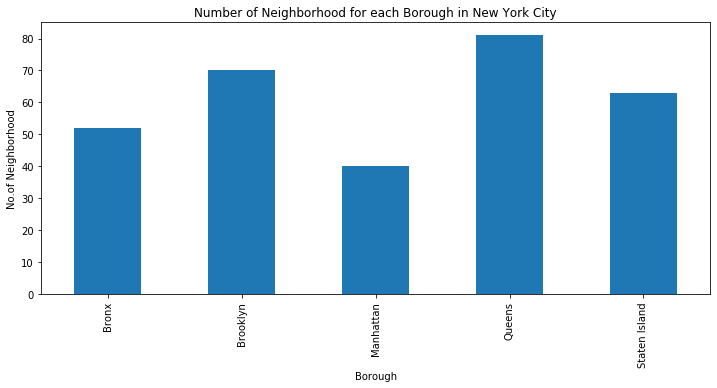

In [5]:
plt.figure(figsize=(12,5))

plt.title('Number of Neighborhood for each Borough in New York City')
plt.xlabel('Borough')
plt.ylabel('No.of Neighborhood')

ny_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')

plt.show()

I tried to create a cluster using all the neighborhoods in ny_df, but when I evaluated it, it was terrible. So this time, we are going to analyze only the queens which have the most neighborhoods.

In [6]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


In [7]:
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

for lat, lng, borough, neighborhood in zip(df_ny['Latitude'], df_ny['Longitude'], df_ny['Borough'], df_ny['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

In [8]:
queens_data = df_ny[df_ny['Borough'] == 'Queens'].reset_index(drop=True)
queens_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Queens,Astoria,40.768509,-73.915654
1,Queens,Woodside,40.746349,-73.901842
2,Queens,Jackson Heights,40.751981,-73.882821
3,Queens,Elmhurst,40.744049,-73.881656
4,Queens,Howard Beach,40.654225,-73.838138


In [9]:
address = 'Queens, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Queens are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Queens are 40.7498243, -73.7976337.


In [10]:
# create map of Manhattan using latitude and longitude values
map_queens = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(queens_data['Latitude'], queens_data['Longitude'], queens_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.7,
        parse_html=False).add_to(map_queens)  
    
map_queens

### Using Foursquare API

In [11]:
CLIENT_ID = '4DUXSRLZUC2ZFHMX2F04Q1RDADVRNFSEWVHJ0GRRU434EYLN' 
CLIENT_SECRET = '0DKE2Y02U0ZIYVKSW3JMIRDWQARNO3ISTKBR2BBG0IDQAO3B'
VERSION = '20180605' 

In [12]:
radius = 600 
LIMIT = 100
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
   longitude, 
    radius, 
   LIMIT)

In [13]:
results = requests.get(url).json()

In [14]:
venues=results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues)
nearby_venues.columns

Index(['referralId', 'reasons.count', 'reasons.items', 'venue.id',
       'venue.name', 'venue.location.address', 'venue.location.crossStreet',
       'venue.location.lat', 'venue.location.lng',
       'venue.location.labeledLatLngs', 'venue.location.distance',
       'venue.location.postalCode', 'venue.location.cc', 'venue.location.city',
       'venue.location.state', 'venue.location.country',
       'venue.location.formattedAddress', 'venue.categories',
       'venue.photos.count', 'venue.photos.groups'],
      dtype='object')

In [15]:
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]
nearby_venues.head()

,venue.name,venue.categories,venue.location.lat,venue.location.lng
0,Pado Sushi Restaurant,"[{'id': '4bf58dd8d48988d113941735', 'name': 'K...",40.753599,-73.794425
1,CVS pharmacy,"[{'id': '4bf58dd8d48988d10f951735', 'name': 'P...",40.753392,-73.792841
2,BB's Pub & Grill,"[{'id': '4bf58dd8d48988d116941735', 'name': 'B...",40.753585,-73.794235
3,Blazin' Burgers & Rotisserie Chicken,"[{'id': '4bf58dd8d48988d16c941735', 'name': 'B...",40.753106,-73.792871
4,Underhill Ave Bike Trail,"[{'id': '56aa371be4b08b9a8d57355e', 'name': 'B...",40.747286,-73.799391


In [16]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [17]:
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns] #cleaning the categories column

nearby_venues.head()

,name,categories,lat,lng
0,Pado Sushi Restaurant,Korean Restaurant,40.753599,-73.794425
1,CVS pharmacy,Pharmacy,40.753392,-73.792841
2,BB's Pub & Grill,Bar,40.753585,-73.794235
3,Blazin' Burgers & Rotisserie Chicken,Burger Joint,40.753106,-73.792871
4,Underhill Ave Bike Trail,Bike Trail,40.747286,-73.799391


### Exploring the neighborhood in Queens

In [18]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [19]:
queens_venues =  getNearbyVenues(names=queens_data['Neighborhood'],
                                   latitudes=queens_data['Latitude'],
                                   longitudes=queens_data['Longitude']
                                  )

Astoria
Woodside
Jackson Heights
Elmhurst
Howard Beach
Corona
Forest Hills
Kew Gardens
Richmond Hill
Flushing
Long Island City
Sunnyside
East Elmhurst
Maspeth
Ridgewood
Glendale
Rego Park
Woodhaven
Ozone Park
South Ozone Park
College Point
Whitestone
Bayside
Auburndale
Little Neck
Douglaston
Glen Oaks
Bellerose
Kew Gardens Hills
Fresh Meadows
Briarwood
Jamaica Center
Oakland Gardens
Queens Village
Hollis
South Jamaica
St. Albans
Rochdale
Springfield Gardens
Cambria Heights
Rosedale
Far Rockaway
Broad Channel
Breezy Point
Steinway
Beechhurst
Bay Terrace
Edgemere
Arverne
Rockaway Beach
Neponsit
Murray Hill
Floral Park
Holliswood
Jamaica Estates
Queensboro Hill
Hillcrest
Ravenswood
Lindenwood
Laurelton
Lefrak City
Belle Harbor
Rockaway Park
Somerville
Brookville
Bellaire
North Corona
Forest Hills Gardens
Jamaica Hills
Utopia
Pomonok
Astoria Heights
Hunters Point
Sunnyside Gardens
Blissville
Roxbury
Middle Village
Malba
Hammels
Bayswater
Queensbridge


In [20]:
print(queens_venues.shape)

(2119, 7)


In [21]:
queens_venues.groupby('Neighborhood').count().head()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Arverne,18,18,18,18,18,18
Astoria,100,100,100,100,100,100
Astoria Heights,11,11,11,11,11,11
Auburndale,19,19,19,19,19,19
Bay Terrace,37,37,37,37,37,37


In [22]:
print('There are {} uniques categories.'.format(len(queens_venues['Venue Category'].unique())))

There are 273 uniques categories.


### Analyzing Each Neighborhoods Through One Hot Encoding

In [24]:
# one hot encoding
queens_onehot = pd.get_dummies(queens_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
queens_onehot['Neighborhood'] = queens_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [queens_onehot.columns[-1]] + list(queens_onehot.columns[:-1])
queens_onehot = queens_onehot[fixed_columns]

queens_onehot.head()

,Yoga Studio,Accessories Store,Afghan Restaurant,Airport Terminal,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Bath House,Beach,Beach Bar,Bed & Breakfast,Beer Garden,Bike Trail,Bistro,Board Shop,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Check Cashing Service,Chinese Restaurant,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Academic Building,College Basketball Court,College Cafeteria,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Cuban Restaurant,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Donut Shop,Dosa Place,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,Event Space,Eye Doctor,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Halal Restaurant,Hardware Store,Health & Beauty Service,Health Food Store,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Hotpot Restaurant,Hunan Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Outdoors & Recreation,Paper / Office Supplies Store,Park,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Service,Pet Store,Pharmacy,Photography Studio,Pier,Pizza Place,Platform,Playground,Plaza,Poke Place,Polish Restaurant,Pool Hall,Post Office,Pub,Ramen Restaurant,Recreation Center,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,Rock Club,Romanian Restaurant,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Snack Place,South American Restaurant,Southern / Soul Food Restaurant,Souvlaki Shop,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,State / Provincial Park,Steakhouse,Storage Facility,Strip Club,Supermarket,Supplement Shop,Surf Spot,Sushi Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Trail,Train,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Weight Loss Center

In [25]:
queens_onehot.shape

(2119, 273)

In [26]:
queens_grouped = queens_onehot.groupby('Neighborhood').mean().reset_index()
queens_grouped.head()

,Neighborhood,Yoga Studio,Accessories Store,Afghan Restaurant,Airport Terminal,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Bath House,Beach,Beach Bar,Bed & Breakfast,Beer Garden,Bike Trail,Bistro,Board Shop,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Check Cashing Service,Chinese Restaurant,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Academic Building,College Basketball Court,College Cafeteria,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Cuban Restaurant,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Donut Shop,Dosa Place,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,Event Space,Eye Doctor,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Halal Restaurant,Hardware Store,Health & Beauty Service,Health Food Store,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Hotpot Restaurant,Hunan Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Nail Salon,New American Restaurant,Nightclub,Noodle House,Office,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Outdoors & Recreation,Paper / Office Supplies Store,Park,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Service,Pet Store,Pharmacy,Photography Studio,Pier,Pizza Place,Platform,Playground,Plaza,Poke Place,Polish Restaurant,Pool Hall,Post Office,Pub,Ramen Restaurant,Recreation Center,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,Rock Club,Romanian Restaurant,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Snack Place,South American Restaurant,Southern / Soul Food Restaurant,Souvlaki Shop,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,State / Provincial Park,Steakhouse,Storage Facility,Strip Club,Supermarket,Supplement Shop,Surf Spot,Sushi Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Trail,Train,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Weight Loss Center

In [27]:
queens_grouped.shape

(81, 273)

Let's put each neighborhood along with the top 10 most common venues into pandas df

In [28]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [30]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = queens_grouped['Neighborhood']

for ind in np.arange(queens_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(queens_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Arverne,Surf Spot,Sandwich Place,Metro Station,Playground,Wine Shop,Pizza Place,Beach,Bus Stop,Thai Restaurant,Board Shop
1,Astoria,Bar,Middle Eastern Restaurant,Greek Restaurant,Hookah Bar,Seafood Restaurant,Mediterranean Restaurant,Deli / Bodega,Indian Restaurant,Gourmet Shop,Bagel Shop
2,Astoria Heights,Plaza,Playground,Burger Joint,Hostel,Italian Restaurant,Pizza Place,Bus Station,Bowling Alley,Business Service,Bakery
3,Auburndale,Italian Restaurant,Bar,Noodle House,Fast Food Restaurant,Korean Restaurant,Furniture / Home Store,Deli / Bodega,Athletics & Sports,Toy / Game Store,Train
4,Bay Terrace,Clothing Store,Women's Store,American Restaurant,Lingerie Store,Mobile Phone Shop,Shoe Store,Kids Store,Donut Shop,Cosmetics Shop,Coffee Shop


### Visualizing and Optimizing the K (the number of cluster)

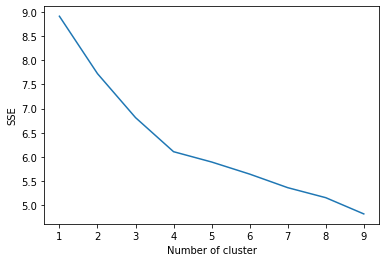

In [32]:
queens_grouped_clustering = queens_grouped.drop('Neighborhood', 1)
sse={}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(queens_grouped_clustering)
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

When first analyzing neighborhoods across New York, it failed to produce meaningful results, but this time it succeeded.

For 2  Clusters  the average silhouette_score is : 0.5433016772259357
For 3  Clusters  the average silhouette_score is : 0.4084975311762999
For 4  Clusters  the average silhouette_score is : 0.3543964719408738
For 5  Clusters  the average silhouette_score is : 0.19666094369390194
For 6  Clusters  the average silhouette_score is : 0.03888436662656723
For 7  Clusters  the average silhouette_score is : 0.26910197028727567


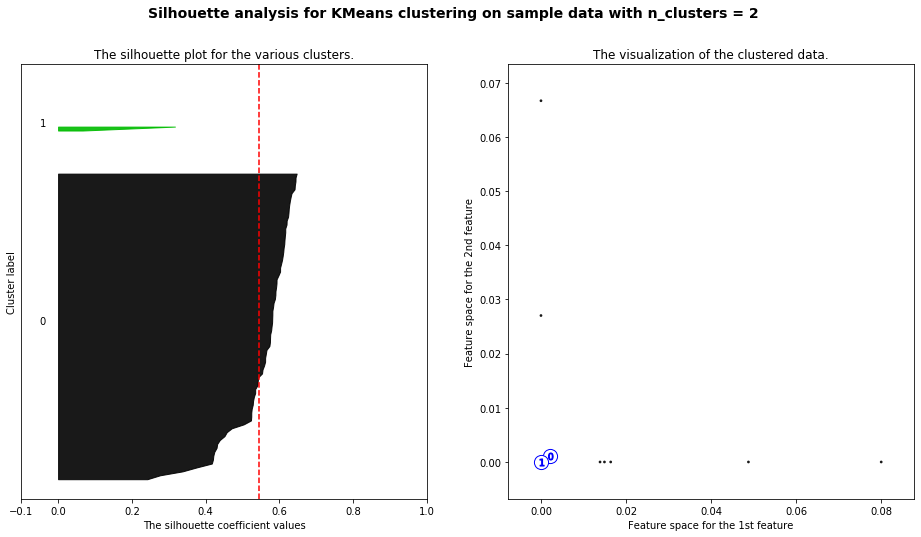

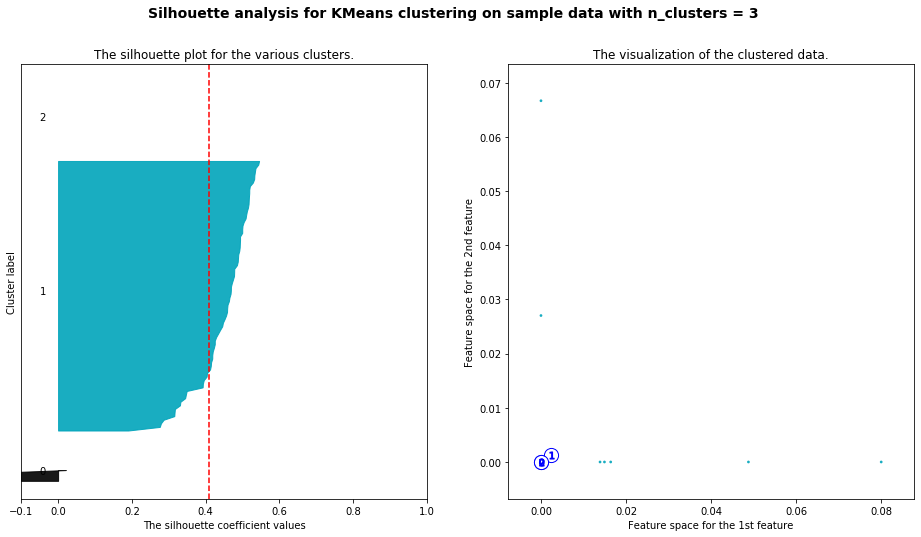

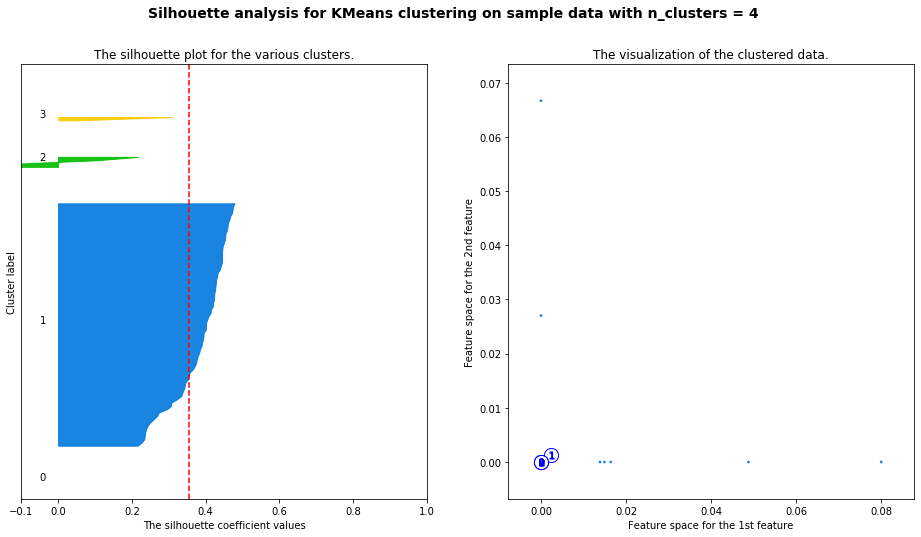

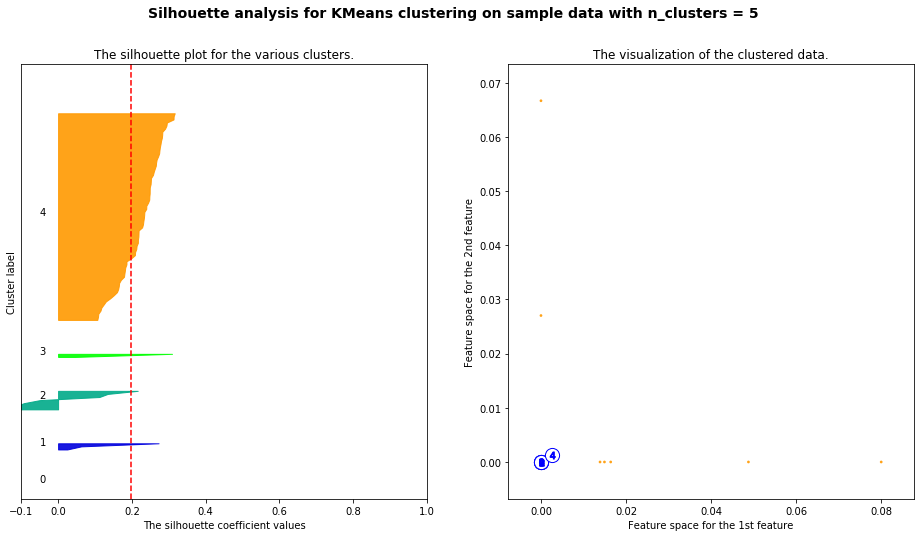

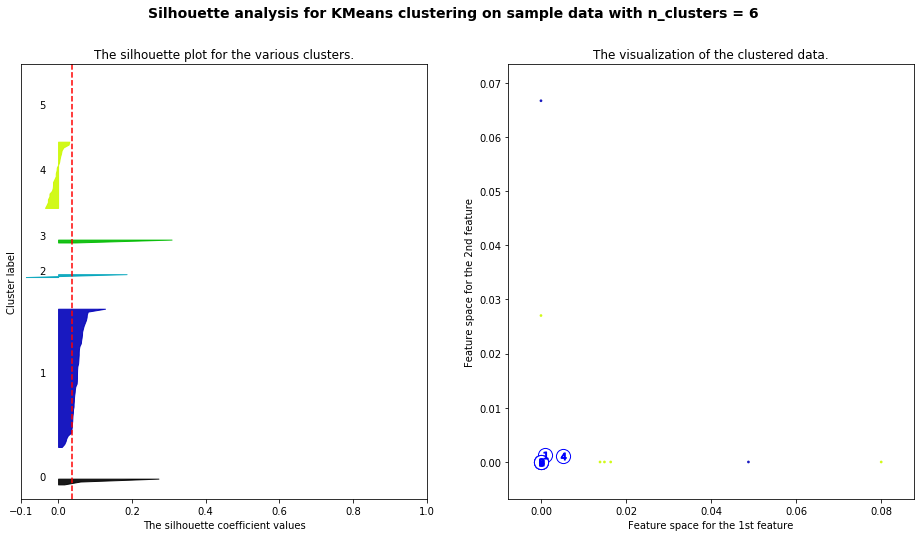

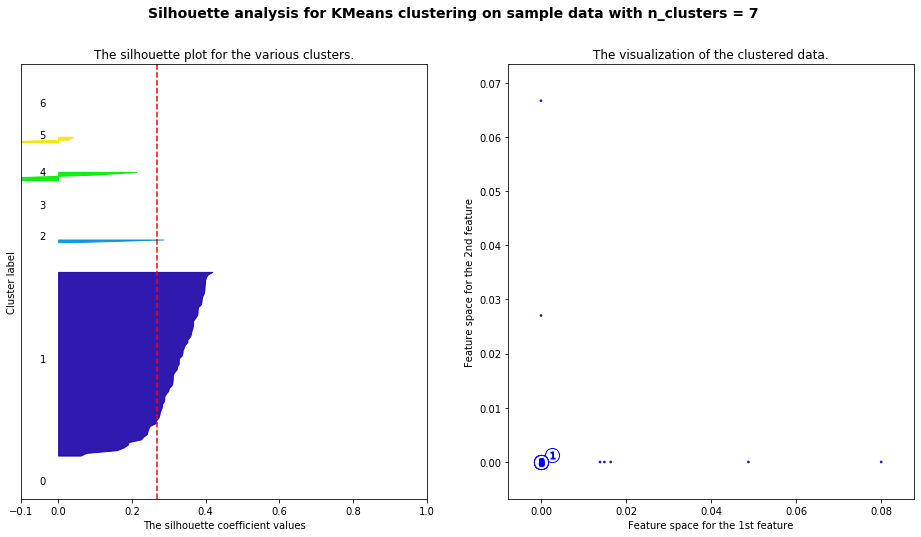

In [42]:
range_n_clusters=[2,3,4,5,6,7]
for n_clusters in range_n_clusters:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(16, 8)
    
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(queens_grouped_clustering) + (n_clusters + 1) * 10])

    clusterer = KMeans(n_clusters=n_clusters, random_state=8)
    cluster_labels = clusterer.fit_predict(queens_grouped_clustering)

    silhouette_avg = silhouette_score(queens_grouped_clustering, cluster_labels)
    print("For", n_clusters, " Clusters  "
          "the average silhouette_score is :", silhouette_avg)

    sample_silhouette_values = silhouette_samples(queens_grouped_clustering, cluster_labels)

    y_lower = 5
    for i in range(n_clusters):
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color1 = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color1, edgecolor=color1, alpha=0.9)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10  

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.axvline(x=silhouette_avg, color="r", linestyle="--")
    ax1.set_yticks([])  
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    colors2 = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(queens_grouped_clustering.iloc[:, 0], queens_grouped_clustering.iloc[:, 1], marker='.', s=30, lw=0, alpha=0.9,
                c=colors2, edgecolor='b')

    centers = clusterer.cluster_centers_
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='b')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='b')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

In [43]:
kclusters = 4

queens_grouped_clustering = queens_grouped.drop('Neighborhood', 1)
kmeans = KMeans(n_clusters=kclusters, random_state=8).fit(queens_grouped_clustering)

In [44]:
queens_merged = queens_data

queens_merged['Cluster Labels'] = kmeans.labels_
queens_merged = queens_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

queens_merged.head()

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Queens,Astoria,40.768509,-73.915654,1,Bar,Middle Eastern Restaurant,Greek Restaurant,Hookah Bar,Seafood Restaurant,Mediterranean Restaurant,Deli / Bodega,Indian Restaurant,Gourmet Shop,Bagel Shop
1,Queens,Woodside,40.746349,-73.901842,1,Grocery Store,Latin American Restaurant,Bakery,Thai Restaurant,Filipino Restaurant,Pizza Place,American Restaurant,Bar,Donut Shop,Pub
2,Queens,Jackson Heights,40.751981,-73.882821,1,Latin American Restaurant,Peruvian Restaurant,South American Restaurant,Bakery,Mexican Restaurant,Thai Restaurant,Mobile Phone Shop,Grocery Store,Spanish Restaurant,Diner
3,Queens,Elmhurst,40.744049,-73.881656,1,Thai Restaurant,Mexican Restaurant,South American Restaurant,Vietnamese Restaurant,Chinese Restaurant,Pizza Place,Gym / Fitness Center,Food Court,Snack Place,Malay Restaurant
4,Queens,Howard Beach,40.654225,-73.838138,1,Italian Restaurant,Pharmacy,Bagel Shop,Deli / Bodega,Sandwich Place,Fast Food Restaurant,Supermarket,Sporting Goods Shop,Mexican Restaurant,Bus Station


In [46]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=9)
import matplotlib.colors as colors
x = np.arange(kclusters)
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]
markers_colors = []
for lat, lon, nei , cluster in zip(queens_merged['Latitude'], queens_merged['Longitude'], queens_merged['Neighborhood'], queens_merged['Cluster Labels']):
    label = folium.Popup(str(nei) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

It seems a little biased ..

### Clustering the Neighborhoods

In [51]:
df1=queens_merged.loc[queens_merged['Cluster Labels'] == 0,queens_merged.columns[[1] + list(range(5, queens_merged.shape[1]))]]
df2=queens_merged.loc[queens_merged['Cluster Labels'] == 1,queens_merged.columns[[1] + list(range(5, queens_merged.shape[1]))]]
df3=queens_merged.loc[queens_merged['Cluster Labels'] == 2,queens_merged.columns[[1] + list(range(5, queens_merged.shape[1]))]]
df4=queens_merged.loc[queens_merged['Cluster Labels'] == 3,queens_merged.columns[[1] + list(range(5, queens_merged.shape[1]))]]

In [55]:
queens_clusters=pd.DataFrame({"Cluster1":df1["Neighborhood"],
                              "Cluster2":df2["Neighborhood"],
                              "Cluster3":df3["Neighborhood"],
                              "Cluster4":df4["Neighborhood"]
                              })

In [56]:
queens_clusters = clusters.replace(np.nan, '', regex=True)
queens_clusters

,Cluster1,Cluster2,Cluster3,Cluster4
0,,Astoria,,
1,,Woodside,,
2,,Jackson Heights,,
3,,Elmhurst,,
4,,Howard Beach,,
5,,Corona,,
6,,,,Forest Hills
7,,Kew Gardens,,
8,,Richmond Hill,,
9,,Flushing,,


In [57]:
queens_final=queens_merged.set_index("Neighborhood",drop=True)

### Conclusion

Although I did my best, I couldn't make a complete program because I had difficulty getting data on additional regions. I plan to supplement the program even after the next course. Thank you.